# Linear Regression

Linear Regression is one of the most fundamental machine learning algorithm.

- build ing a Linear Regression model
- various assumption
- evaluation metrics

## Variables

Variables capture data information in different forms.
- Numerical
- Categorical

## correlation coefficient

- range form -1 to +1
- Negative : increasing one of the variable, the other variable decrease.
- Postive : increasing one of the variable, the other variable increase.
- Non-linear : little complex and hence reauire an extra information to predict the target value.

# Demo

- make a toy data
- visualization toy data

In [1]:
import pandas as pd
toy_data = pd.DataFrame({'id':[1,2,3,4], 'age':[20, 30, 40, 50], 'salary':[5, 10, 15, 22]})
toy_data

,id,age,salary
0,1,20,5
1,2,30,10
2,3,40,15
3,4,50,22


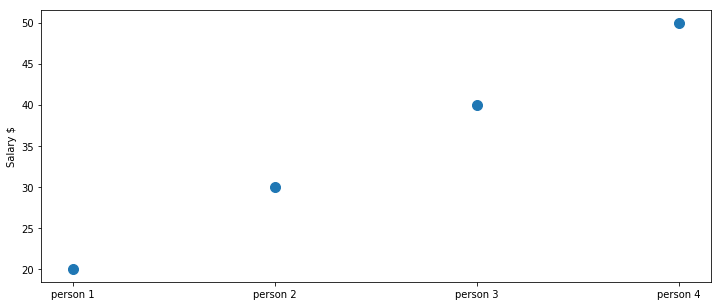

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.scatter(range(4), toy_data.age, s=100)
plt.xticks(range(4), ['person 1', 'person 2', 'person 3', 'person 4'])
plt.ylabel('Salary $')
plt.show()

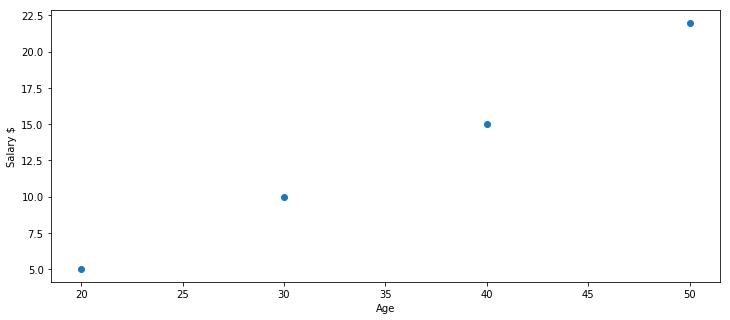

In [10]:
plt.figure(figsize=(12, 5))
plt.scatter(toy_data.age, toy_data.salary)
plt.xlabel('Age')
plt.ylabel('Salary $')
plt.show()

Ovserve, Age , Salary seems to be positive correlation.

# Regularization techniques(improve generalization)

- Ridge Regression(L2), regularization : restricting the coefficient values of input features close to zero
- Lasso Regression(L1), make some of the coefficients zero in order 
- Elasticnet , combination L1&L2

# Linear Regression's assumptions:
- input variable and output variable must be linear relationship(线性:在数学上可以理解为一阶导数为常数的函数)
- input variables should not be correlated to each other(multicollinearity)
- residuals/error values must be no correlation
- residuals and output variable must be a linear relationship
- residuals/error values must be normally

# building a Linear Regression Model using PySpark

$$ y = b_0 +b_1 * x_1 + b_2 * x_2 +b_3 * x_3 + ....$$
----

#### Create the SparkSession object

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('LR').getOrCreate()

### load dataset

In [3]:
df = spark.read.csv('./Data/Linear_regression_dataset.csv', inferSchema=True, header=True)

### EDA(exploratory data analysis)
- shape of the dataset
- various statistical measures
- correlations

In [5]:
print((df.count(), len(df.columns)))

(1232, 6)


In [6]:
df.printSchema()

root
 |-- var_1: integer (nullable = true)
 |-- var_2: integer (nullable = true)
 |-- var_3: integer (nullable = true)
 |-- var_4: double (nullable = true)
 |-- var_5: double (nullable = true)
 |-- output: double (nullable = true)



In [7]:
df.describe().show(4, False)

+-------+-----------------+-----------------+------------------+--------------------+--------------------+-------------------+
|summary|var_1            |var_2            |var_3             |var_4               |var_5               |output             |
+-------+-----------------+-----------------+------------------+--------------------+--------------------+-------------------+
|count  |1232             |1232             |1232              |1232                |1232                |1232               |
|mean   |715.0819805194806|715.0819805194806|80.90422077922078 |0.3263311688311693  |0.25927272727272715 |0.39734172077922014|
|stddev |91.5342940441652 |93.07993263118064|11.458139049993724|0.015012772334166148|0.012907228928000298|0.03326689862173776|
|min    |463              |472              |40                |0.277               |0.214               |0.301              |
+-------+-----------------+-----------------+------------------+--------------------+--------------------+-----

In [8]:
df.head(3)

[Row(var_1=734, var_2=688, var_3=81, var_4=0.328, var_5=0.259, output=0.418),
 Row(var_1=700, var_2=600, var_3=94, var_4=0.32, var_5=0.247, output=0.389),
 Row(var_1=712, var_2=705, var_3=93, var_4=0.311, var_5=0.247, output=0.417)]

## corr

In [18]:
from pyspark.sql.functions import corr

for col_name in df.columns[:-1]:
    print(col_name)
    print(df.select(corr(col_name, 'output')).show())

var_1
+-------------------+
|corr(var_1, output)|
+-------------------+
| 0.9187399607627283|
+-------------------+

None
var_2
+-------------------+
|corr(var_2, output)|
+-------------------+
|0.43652698913681093|
+-------------------+

None
var_3
+-------------------+
|corr(var_3, output)|
+-------------------+
| 0.4014958408311139|
+-------------------+

None
var_4
+-------------------+
|corr(var_4, output)|
+-------------------+
| 0.7909100204842113|
+-------------------+

None
var_5
+-------------------+
|corr(var_5, output)|
+-------------------+
| 0.7904806260381185|
+-------------------+

None


# Feature preprocessing

In [19]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [20]:
vec_assmebler = VectorAssembler(inputCols =['var_1', 'var_2', 'var_3', 'var_4', 'var_5'], outputCol='features')
features_df = vec_assmebler.transform(df)
features_df.printSchema()

root
 |-- var_1: integer (nullable = true)
 |-- var_2: integer (nullable = true)
 |-- var_3: integer (nullable = true)
 |-- var_4: double (nullable = true)
 |-- var_5: double (nullable = true)
 |-- output: double (nullable = true)
 |-- features: vector (nullable = true)



In [21]:
features_df.select('features').show(5, False)

+------------------------------+
|features                      |
+------------------------------+
|[734.0,688.0,81.0,0.328,0.259]|
|[700.0,600.0,94.0,0.32,0.247] |
|[712.0,705.0,93.0,0.311,0.247]|
|[734.0,806.0,69.0,0.315,0.26] |
|[613.0,759.0,61.0,0.302,0.24] |
+------------------------------+
only showing top 5 rows



In [22]:
model_df = features_df.select('features', 'output')
model_df.show(5, False)

+------------------------------+------+
|features                      |output|
+------------------------------+------+
|[734.0,688.0,81.0,0.328,0.259]|0.418 |
|[700.0,600.0,94.0,0.32,0.247] |0.389 |
|[712.0,705.0,93.0,0.311,0.247]|0.417 |
|[734.0,806.0,69.0,0.315,0.26] |0.415 |
|[613.0,759.0,61.0,0.302,0.24] |0.378 |
+------------------------------+------+
only showing top 5 rows



In [23]:
print((model_df.count(), len(model_df.columns)))

(1232, 2)


### split train/test

In [24]:
train_df, test_df = model_df.randomSplit([0.7, 0.3])
print('train set')
print((train_df.count(), len(train_df.columns)))
print('test set')
print((test_df.count(), len(test_df.columns)))

train set
(861, 2)
test set
(371, 2)


## Training LR model

In [25]:
from pyspark.ml.regression import LinearRegression

LR = LinearRegression(labelCol='output')
lr_model = LR.fit(train_df)

print('lr  coefficients :')
print(lr_model.coefficients)

lr  coefficients :
[0.00035501870753228425,4.666724142749286e-05,0.00017802249212078004,-0.733551988071623,0.5314722647490763]


In [26]:
print('intercept :')
print(lr_model.intercept)

intercept :
0.197204233252839


In [27]:
# train score
train_pred = lr_model.evaluate(train_df)
print(train_pred.r2)

0.8725246957573798


### evaluate on test data

In [28]:
test_pred = lr_model.evaluate(test_df)
print(test_pred.r2)
print('mean squared error')
print(test_pred.meanSquaredError)

0.8587328958053622
mean squared error
0.00014045457381890505
